In [2]:
import pickle
import numpy as np
from sklearn.cluster import SpectralClustering
from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
import os
import json
import math
from copy import deepcopy

In [3]:
def get_contiguous_stamps(stamps):
    lines = deepcopy(stamps)
    contiguous_stamps = []
    for i in range(len(lines)-1):
        start, end, label = lines[i].split()
        next_start, next_end, next_label = lines[i+1].split()
        if float(end) > float(next_start):
            avg = str((float(next_start) + float(end)) / 2.0)
            lines[i+1] = ' '.join([avg, next_end, next_label])
            contiguous_stamps.append(start + " " + avg + " " + label)
        else:
            contiguous_stamps.append(start + " " + end + " " + label)
    start, end, label = lines[-1].split()
    contiguous_stamps.append(start + " " + end + " " + label)
    return contiguous_stamps


def merge_stamps(lines):
    stamps = deepcopy(lines)
    overlap_stamps = []
    for i in range(len(stamps)-1):
        start, end, label = stamps[i].split()
        next_start, next_end, next_label = stamps[i+1].split()
        if float(end) == float(next_start) and label == next_label:
            stamps[i+1] = ' '.join([start, next_end, next_label])   
        else:
            overlap_stamps.append(start + " " + end + " " + label)
    
    start, end, label = stamps[-1].split()
    overlap_stamps.append(start + " " + end + " " + label)
    
    return overlap_stamps

def combine_stamps(stamps):
    combine=[]
    idx = 0
    prev_start,prev_end,prev_speaker = stamps[idx].split()
    while idx < len(stamps)-1:
        idx+=1
        start,end,speaker = stamps[idx].split()
        if speaker == prev_speaker and start <= prev_end:
            prev_end = end
        else:
            combine.append("{} {} {}".format(prev_start,prev_end,prev_speaker))
            prev_start = start
            prev_end = end
            prev_speaker = speaker
        
    combine.append("{} {} {}".format(prev_start,end,speaker))
    return combine  

def write_audacity_file(labels,filename):
    with open(filename,'w') as f:
        for line in labels:
            start,end,speaker = line.strip().split()
            f.write("{}\t{}\t{}\n".format(start,end,speaker))
    print("wrote labels to audacity type label file at ",filename)

def labels_to_pyannote_object(labels):
    annotation = Annotation()
    for label in labels:
        start,end,speaker = label.strip().split()
        start,end = float(start),float(end)
        annotation[Segment(start,end)]=speaker
    
    return annotation

def rttm_to_audacity_labels(rttm_filename,write=False):
    outname = rttm_filename.split('/')[-1]
    outname = outname[:-5]+'.txt'
    labels=[]
    if write:
        g=open(outname,'w')
    with open(rttm_filename,'r') as f:
        for line in f.readlines():
            rttm = line.strip().split()
            start,end,speaker = float(rttm[3]),float(rttm[4])+float(rttm[3]),rttm[7]
            labels.append('{} {} {}'.format(start,end,speaker))
            if write:
                g.write("{}\t{}\t{}\n".format(start,end,speaker))
    if write:
        print("wrote to {}".format(outname))
        g.close()
    else:
        return labels

In [10]:
embeddings_file = 'test_diarize_embeddings.pkl'
reco2num = '/disk2/datasets/NIST_SRE_2000_LDC2001S97/NIST_SRE_2000_LDC2001S97_16k/reco2num'
RTTM_DIR= '/disk2/datasets/NIST_SRE_2000_LDC2001S97/NIST_SRE_2000_LDC2001S97_16k/disk8_RTTMs'
# '/disk2/datasets/FisherEnglishTrainingSpeech/RTTM/'

manifest_path = '/disk2/datasets/NIST_SRE_2000_LDC2001S97/NIST_SRE_2000_LDC2001S97_16k/test_diarize.json'
# /disk2/datasets/NIST_SRE_2000_LDC2001S97/NIST_SRE_2000_LDC2001S97_16k/test_diarize.json'
# '/disk2/datasets/FisherEnglishTrainingSpeech/vad_output/speaker.json'


embeddings = pickle.load(open(embeddings_file,'rb'))
num_files = len(embeddings.keys())
print("Number of files to diarize: ",num_files)
sample = list(embeddings.keys())[0]
print("sample '{}' embeddings shape is {}\n".format(sample, embeddings[sample][0].shape))

WINDOW=1.5
SHIFT=0.75
SAMPLE_RATE=16000
all_hypothesis=[]
all_reference=[]

SPEAKERS = {}
if type(reco2num) is int:
    for key in embeddings.keys():
        SPEAKERS[key]=reco2num
else:
    for key in open(reco2num).readlines():
        key = key.strip()
        wav_id, num = key.split()
        SPEAKERS[wav_id] = int(num)

with open(manifest_path,'r') as manifest:
    time_stamps={}
    for line in manifest.readlines():
        line = line.strip()
        line = json.loads(line)
        audio,offset,duration = line['audio_filepath'],line['offset'],line['duration']
        audio = os.path.basename(audio).split('.')[0]
        if audio not in time_stamps:
            time_stamps[audio]=[]
        start = offset
        base = math.ceil((duration-WINDOW)/SHIFT) 
        slices = 1 if base < 0 else base + 1 
        for slice_id in range(slices):
            end = start + WINDOW
            stamp = '{:.3f} {:.3f} '.format(start,end)
            time_stamps[audio].append(stamp)
            start = offset + (slice_id+1)*SHIFT

Number of files to diarize:  2
sample 'iafs' embeddings shape is (256,)



In [11]:
for uniq_key in embeddings.keys():
    NUM_SPEAKERS = SPEAKERS[uniq_key]
    if NUM_SPEAKERS>=2:
        emb = embeddings[uniq_key]
        emb = np.asarray(emb)
        cluster_method = SpectralClustering(n_clusters=NUM_SPEAKERS,random_state=42)
        cluster_method.fit(emb)
        lines = time_stamps[uniq_key]
        cluster_labels = cluster_method.labels_
        assert len(cluster_labels)==len(lines)
        for idx,label in enumerate(cluster_labels):
            tag = 'speaker_'+str(label)
            lines[idx]+=tag
        #ReSegmentation -> VAD and Segmented Results 
        a = get_contiguous_stamps(lines)
        labels = merge_stamps(a)
        hypothesis = labels_to_pyannote_object(labels)
        all_hypothesis.append(hypothesis)
#         write_audacity_file(labels,uniq_key[:-4]+'.txt')
        
        rttm_file=os.path.join(RTTM_DIR,uniq_key+'.rttm')
        ref_labels = rttm_to_audacity_labels(rttm_file)
#         ref_labels = combine_stamps(ref_labels)
        reference = labels_to_pyannote_object(ref_labels)
        all_reference.append(reference)

AssertionError: 

In [12]:
uniq_key

'iait'

In [15]:
time_stamps['iait'].__len__()

734

In [16]:
embeddings['iait'].__len__()

1065

In [8]:
metric = DiarizationErrorRate()
for reference, hypothesis in zip(all_reference,all_hypothesis):
    metric(reference,hypothesis,detailed=True)

print("overall DER: {:.3f}".format(abs(metric)))
metric[:]

/home/nithin-dl1804/.conda/envs/NeMo/lib/python3.6/site-packages/pyannote/metrics/utils.py:184: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  "'uem' was approximated by the union of 'reference' "


overall DER: 0.485


{'missed detection': 10540.060499999996,
 'false alarm': 3920.1859999999956,
 'correct': 36973.478,
 'total': 64221.34400000001,
 'confusion': 16707.80549999999}

In [9]:
reference = labels_to_pyannote_object(ref_labels)

In [10]:
print('**')

**


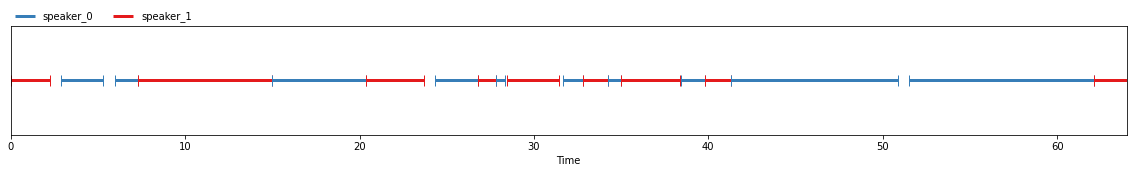

In [11]:
hypothesis

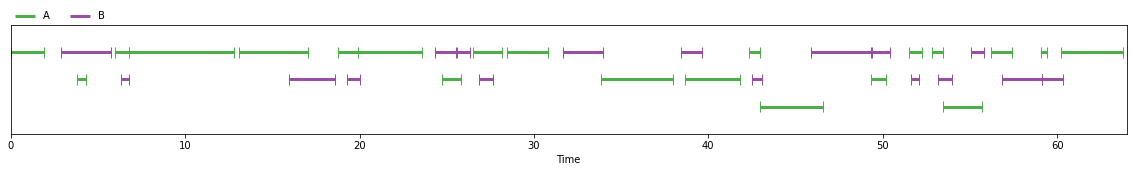

In [12]:
reference

In [8]:
time_stamps

{'iafs': ['0.000 1.500 ',
  '1.203 2.703 ',
  '1.953 3.453 ',
  '2.703 4.203 ',
  '3.464 4.964 ',
  '5.261 6.761 ',
  '6.011 7.511 ',
  '6.761 8.261 ',
  '7.511 9.011 ',
  '8.180 9.680 ',
  '8.930 10.430 ',
  '10.222 11.722 ',
  '10.972 12.472 ',
  '11.722 13.222 ',
  '13.717 15.217 ',
  '13.918 15.418 ',
  '15.333 16.833 ',
  '16.083 17.583 ',
  '16.833 18.333 ',
  '15.589 17.089 ',
  '17.532 19.032 ',
  '17.910 19.410 ',
  '19.073 20.573 ',
  '19.823 21.323 ',
  '19.682 21.182 ',
  '21.462 22.962 ',
  '22.212 23.712 ',
  '22.962 24.462 ',
  '23.082 24.582 ',
  '24.512 26.012 ',
  '25.262 26.762 ',
  '26.012 27.512 ',
  '26.762 28.262 ',
  '27.512 29.012 ',
  '28.262 29.762 ',
  '29.012 30.512 ',
  '30.222 31.722 ',
  '30.972 32.472 ',
  '32.382 33.882 ',
  '33.132 34.632 ',
  '33.882 35.382 ',
  '34.632 36.132 ',
  '35.382 36.882 ',
  '33.712 35.212 ',
  '36.719 38.219 ',
  '37.469 38.969 ',
  '38.219 39.719 ',
  '38.969 40.469 ',
  '39.281 40.781 ',
  '40.031 41.531 ',
  '40.781 42.